# [ node2vec implementation ]
- with Football dataset

# 1. Import Dataset  & Libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

%matplotlib inline

In [2]:
H = nx.read_gml('football.gml')

adjacent matrix & one-hot encoded matrix

In [3]:
A = nx.to_numpy_matrix(H,nodelist=H.nodes())

# 2. Define functions

#### 1) sigmoid

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

#### 2) pos_list & neg_list : getting the positive & negative nodes

In [5]:
def pos_list(node):
    return np.nonzero(A[node])[1]    

def neg_list(node):
    return np.where(A[node]==0)[1]

#### 3) next_choice : choosing the next step according to the transition probability, considering the previous state

- (1) previous : 't'
- (2) now : 'v'
- (3) next : 'x'

In [6]:
def next_choice(v,t,p,q):
    positive = pos_list(v)
    li = np.array([])
    for pos in positive:
        if pos==t:
            li = np.append(li,1/p)
        elif pos in pos_list(t):
            li = np.append(li,1)
        else :
            li = np.append(li,1/q)
    
    prob = li/li.sum()
    
    return np.random.choice(positive,1,p=prob)[0]

#### 4) random_step : getting the random step, using next_choice

In [7]:
def random_step(v,num_walk,p,q):
    t = np.random.choice(pos_list(v)) # (1) previous
    
    walk_list = [v]
    for _ in range(num_walk):
        x = next_choice(v,t,p,q)
        walk_list.append(x)
        v = x
        t = v
    return walk_list

# 3. node2vec

In [8]:
def node2vec(dim,num_epoch,length,lr,k,p,q,num_neg):   
    embed = np.random.random((A.shape[0],dim))
    
    for epoch in range(num_epoch):        
        for v in np.arange(A.shape[0]):         
            walk = random_step(v,length-1,p,q) # (1) random walk                             
            
            for idx in range(length-k):     
            
                not_neg_list = np.append(walk[max(0,idx-k):idx+k],pos_list(walk[idx]))
                neg_list = list(set(np.arange(A.shape[0])) - set(not_neg_list))
                random_neg = np.random.choice(neg_list,num_neg,replace=False)
                            
                for pos in range(idx+1,idx+k+1):                                        
                    if walk[idx]!=walk[pos]:                
                        pos_embed = embed[walk[pos]] 
                        embed[walk[idx]] -= lr * (sigmoid(np.dot(embed[walk[idx]],pos_embed))-1) * pos_embed
                
                for neg in random_neg:
                    neg_embed = embed[neg]
                    embed[walk[idx]] -= lr * (sigmoid(np.dot(embed[walk[idx]],neg_embed))) * neg_embed

    return embed

# 4. Result

In [13]:
embed = node2vec(dim=2,num_epoch=50,length=8,lr=0.02,
                 k=2,p=2,q=2,num_neg=5)

In [18]:
def visualize(Emb):    
    Emb_df = pd.DataFrame(Emb)
    Emb_df['Label'] = dict(H.node('value')).values()

    Emb_df.loc[Emb_df.Label==0,'Color']='#F22F2F'
    Emb_df.loc[Emb_df.Label==1,'Color']='#F5A913'
    Emb_df.loc[Emb_df.Label==2,'Color']='#F5F513'
    Emb_df.loc[Emb_df.Label==3,'Color']='#8BF513'
    Emb_df.loc[Emb_df.Label==4,'Color']='#8DBA5A'
    Emb_df.loc[Emb_df.Label==5,'Color']='#25FDFD'
    Emb_df.loc[Emb_df.Label==6,'Color']='#25A7FD'
    Emb_df.loc[Emb_df.Label==7,'Color']='#1273B3'
    Emb_df.loc[Emb_df.Label==8,'Color']='#8E12B3'
    Emb_df.loc[Emb_df.Label==9,'Color']='#EBCAF5'
    Emb_df.loc[Emb_df.Label==10,'Color']='#D468C2'
    Emb_df.loc[Emb_df.Label==11,'Color']='#1C090D'
    
    plt.scatter(Emb_df[0],Emb_df[1],c=Emb_df['Color'])
    return Emb_df

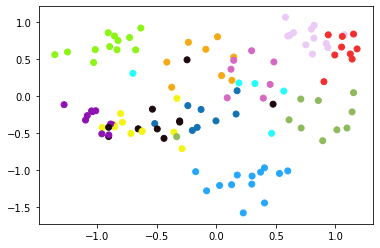

In [20]:
embedded = visualize(embed)

In [21]:
pd.DataFrame(embedded).to_csv('Football_embedded_node2vec.csv')